# **Week 5: Route and Airport-Level Analysis**

In [0]:
import pandas as pd
output_path = "/Volumes/workspace/airlines/flight/cleaned_dataset.csv"
data = pd.read_csv(output_path)
display(data.head(10))

DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Org_Airport,Dest,Dest_Airport,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DurationDiff,DepDelayed_Flag,ArrDelayed_Flag,TotalDelay,Month,DayOfWeekNum,DayName,Hour,Route,IsWeekend,TIME_OF_DAY
4,2019-03-01,18:29:00,1959,1925,11,9,3920,N464WN,90,90,77,34,34,124,105,42,15,515,3,10,0,0,0,2,0,0,0,32,0,1,1,34,3,4,Friday,null,124 → 42,0,Unknown
4,2019-03-01,19:37:00,2037,1940,11,9,509,N763SW,240,250,230,57,67,124,105,138,143,1591,3,7,0,0,0,10,0,0,0,47,-10,1,1,57,3,4,Friday,null,124 → 138,0,Unknown
4,2019-03-01,16:44:00,1845,1725,11,9,1333,N334SW,121,135,107,80,94,124,105,158,172,828,6,8,0,0,0,8,0,0,0,72,-14,1,1,80,3,4,Friday,null,124 → 158,0,Unknown
4,2019-03-01,14:52:00,1640,1625,11,9,675,N286WN,228,240,213,15,27,124,105,199,178,1489,7,8,0,0,0,3,0,0,0,12,-12,1,1,15,3,4,Friday,null,124 → 199,0,Unknown
4,2019-03-01,13:23:00,1526,1510,11,9,4,N674AA,123,135,110,16,28,124,105,256,226,838,4,9,0,0,0,0,0,0,0,16,-12,1,1,16,3,4,Friday,null,124 → 256,0,Unknown
4,2019-03-01,14:16:00,1512,1435,11,9,54,N643SW,56,70,49,37,51,126,132,42,15,220,2,5,0,0,0,12,0,0,0,25,-14,1,1,37,3,4,Friday,null,126 → 42,0,Unknown
4,2019-03-01,16:57:00,1754,1735,11,9,623,N724SW,57,70,47,19,32,126,132,42,15,220,5,5,0,0,0,7,0,0,0,12,-13,1,1,19,3,4,Friday,null,126 → 42,0,Unknown
4,2019-03-01,14:22:00,1657,1610,11,9,188,N215WN,155,195,143,47,87,126,132,93,77,1093,6,6,0,0,0,40,0,0,0,7,-40,1,1,47,3,4,Friday,null,126 → 93,0,Unknown
4,2019-03-01,21:07:00,2334,2230,11,9,362,N798SW,147,165,134,64,82,126,132,158,172,972,6,7,0,0,0,5,0,0,0,59,-18,1,1,64,3,4,Friday,null,126 → 158,0,Unknown
4,2019-03-01,18:12:00,1927,1815,11,9,422,N779SW,135,145,118,72,82,126,132,160,43,765,6,11,0,0,0,3,0,0,0,69,-10,1,1,72,3,4,Friday,null,126 → 160,0,Unknown


Org_Airport,Dest_Airport,Flight_Count,Route
251,53,949,251 → 53
142,134,921,142 → 134
52,251,845,52 → 251
205,134,816,205 → 134
178,143,815,178 → 143
133,205,705,133 → 205
133,170,701,133 → 170
58,143,695,58 → 143
133,168,681,133 → 168
178,204,670,178 → 204


/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-8376522952111478-1313713567:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


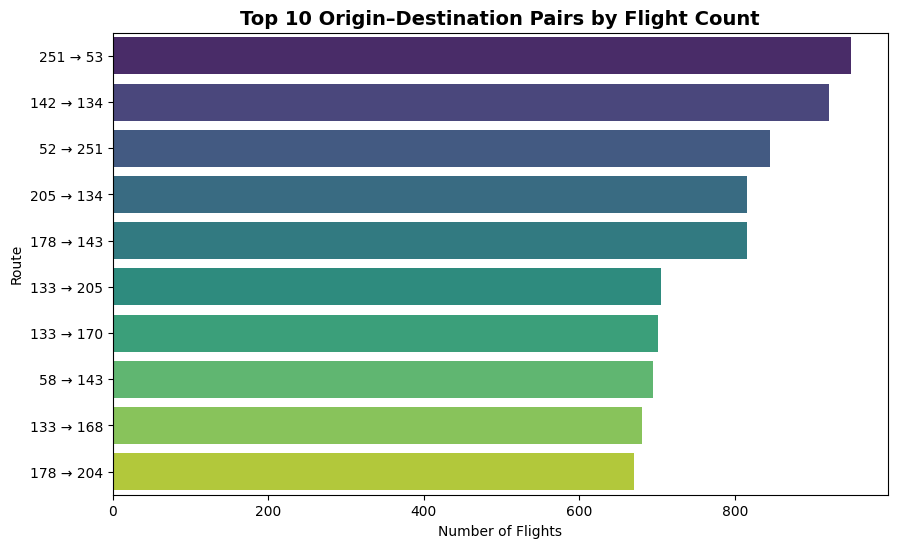

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

if all(col in data.columns for col in ['Org_Airport', 'Dest_Airport']):
    top_routes = (
        data.groupby(['Org_Airport', 'Dest_Airport'])
        .size()
        .reset_index(name='Flight_Count')
        .sort_values(by='Flight_Count', ascending=False)
        .head(10)
    )
    top_routes['Route'] = (
        top_routes['Org_Airport'].astype(str) + ' → ' + top_routes['Dest_Airport'].astype(str)
    )
    display(top_routes)
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_routes,
        x='Flight_Count',
        y='Route',
        palette='viridis'
    )
    plt.title("Top 10 Origin–Destination Pairs by Flight Count", fontsize=14, fontweight='bold')
    plt.xlabel("Number of Flights")


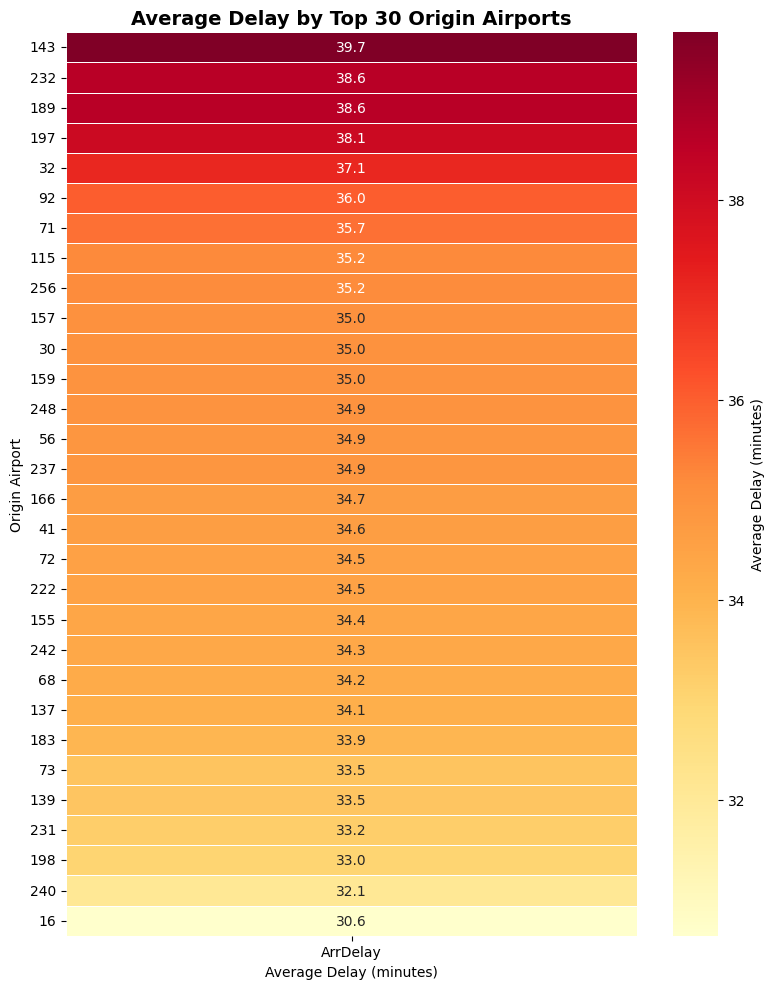

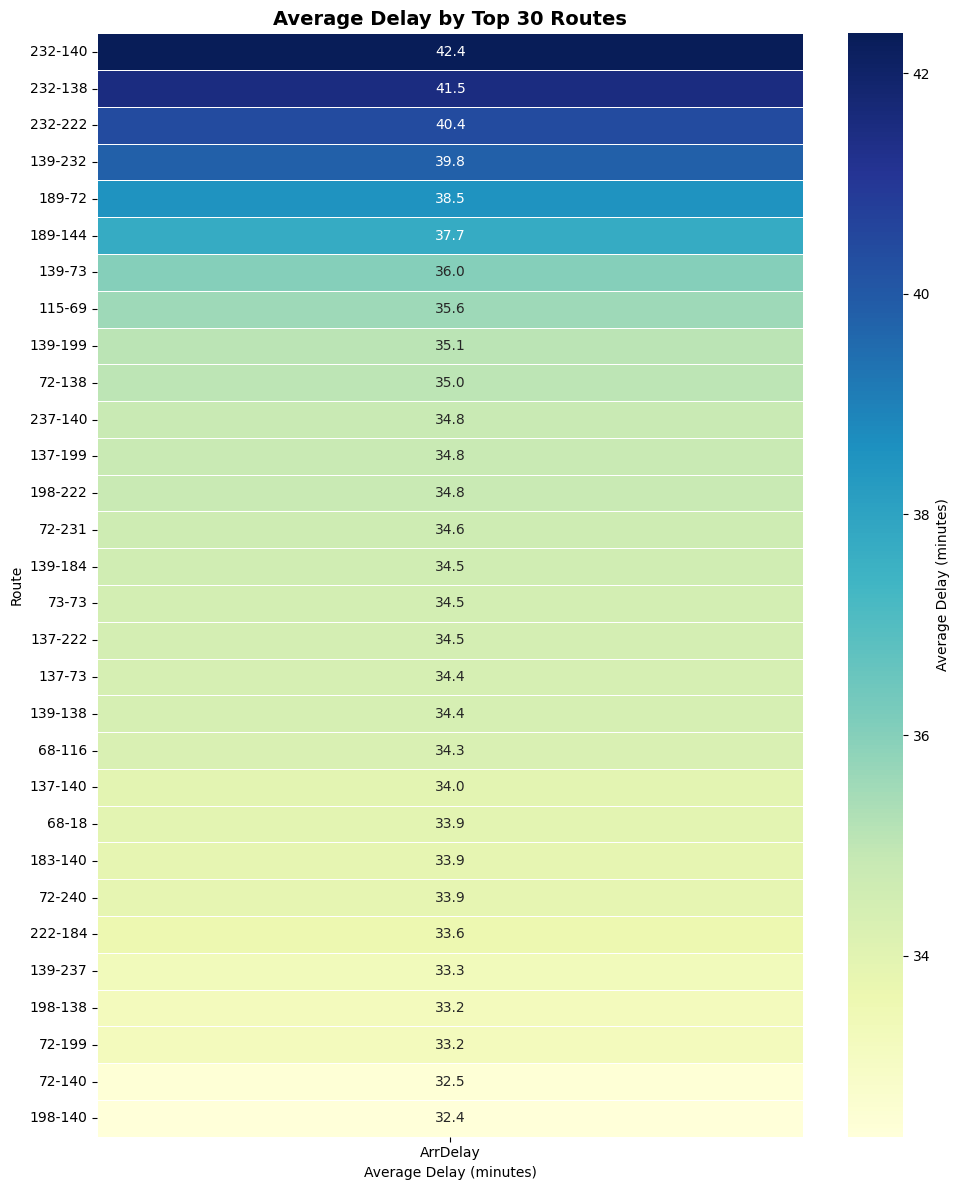


**Observation:**
- The heatmaps above show the average delay (in minutes) for the top 30 origin airports and top 30 routes.
- The airport with the highest average delay is **143.0** with **39.7** minutes.
- The airport with the lowest average delay among the top 30 is **16.0** with **30.6** minutes.
- The route with the highest average delay is **232-140** with **42.4** minutes.
- The route with the lowest average delay among the top 30 is **198-140** with **32.4** minutes.
- These insights can help identify bottlenecks and efficient corridors in the flight network.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

delay_candidates = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DELAY', 'DEP_DELAY', 'ARR_DELAY']
origin_candidates = ['ORIGIN', 'ORIGIN_AIRPORT', 'ORIGIN_AIRPORT_CODE', 'AIRPORT']
dest_candidates = ['DEST', 'DESTINATION', 'DEST_AIRPORT', 'DEST_AIRPORT_CODE']

def find_col(candidates, df):
    for c in candidates:
        if c in df.columns:
            return c
    for c in candidates:
        for col in df.columns:
            if c.lower() in col.lower():
                return col
    return None

delay_col = find_col(delay_candidates, data)
origin_col = find_col(origin_candidates, data)
dest_col = find_col(dest_candidates, data)

if not delay_col or not origin_col or not dest_col:
    raise ValueError("Could not find suitable delay, origin, or destination columns in your dataset!")

if 'ROUTE' not in data.columns:
    data['ROUTE'] = data[origin_col].astype(str) + '-' + data[dest_col].astype(str)

data[delay_col] = pd.to_numeric(data[delay_col], errors='coerce')
top_30_airports = data[origin_col].value_counts().nlargest(30).index
top_30_routes = data['ROUTE'].value_counts().nlargest(30).index
airport_data = data[data[origin_col].isin(top_30_airports)]
route_data = data[data['ROUTE'].isin(top_30_routes)]
airport_delay = (
    airport_data.groupby(origin_col)[delay_col]
    .mean()
    .reset_index()
    .sort_values(by=delay_col, ascending=False)
)
route_delay = (
    route_data.groupby('ROUTE')[delay_col]
    .mean()
    .reset_index()
    .sort_values(by=delay_col, ascending=False)
)
airport_pivot = airport_delay.set_index(origin_col)
route_pivot = route_delay.set_index('ROUTE')
plt.figure(figsize=(8, 10))
sns.heatmap(
    airport_pivot,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={'label': 'Average Delay (minutes)'}
)
plt.title("Average Delay by Top 30 Origin Airports", fontsize=14, fontweight='bold')
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Origin Airport")
plt.tight_layout()
display(plt.gcf())
plt.close()

plt.figure(figsize=(10, 12))
sns.heatmap(
    route_pivot,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Average Delay (minutes)'}
)
plt.title("Average Delay by Top 30 Routes", fontsize=14, fontweight='bold')
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Route")
plt.tight_layout()
display(plt.gcf())
plt.close()

# Add insights/observation
max_airport = airport_delay.iloc[0][origin_col]
max_airport_delay = airport_delay.iloc[0][delay_col]
min_airport = airport_delay.iloc[-1][origin_col]
min_airport_delay = airport_delay.iloc[-1][delay_col]

max_route = route_delay.iloc[0]['ROUTE']
max_route_delay = route_delay.iloc[0][delay_col]
min_route = route_delay.iloc[-1]['ROUTE']
min_route_delay = route_delay.iloc[-1][delay_col]

observation = f"""
**Observation:**
- The heatmaps above show the average delay (in minutes) for the top 30 origin airports and top 30 routes.
- The airport with the highest average delay is **{max_airport}** with **{max_airport_delay:.1f}** minutes.
- The airport with the lowest average delay among the top 30 is **{min_airport}** with **{min_airport_delay:.1f}** minutes.
- The route with the highest average delay is **{max_route}** with **{max_route_delay:.1f}** minutes.
- The route with the lowest average delay among the top 30 is **{min_route}** with **{min_route_delay:.1f}** minutes.
- These insights can help identify bottlenecks and efficient corridors in the flight network.
"""
display(Markdown(observation))

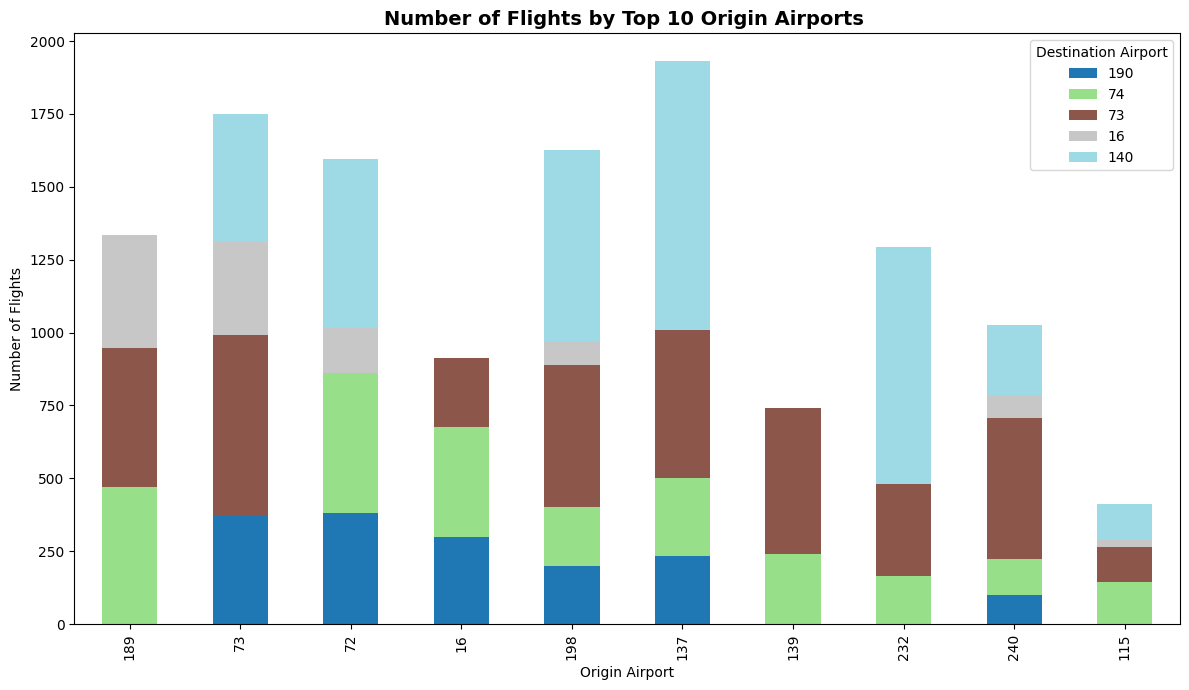


**Observation:**
- The stacked bar chart shows the distribution of flights from the top 10 origin airports to the top 5 destination airports.
- The origin airport with the highest total number of flights (to these top destinations) is **137** with **1930** flights.
- The most popular destination among these is **140** with **3776** flights from the top origins.
- This visualization highlights key airport hubs and their most frequent connections.


In [0]:
top_10_origins = data[origin_col].value_counts().nlargest(10).index
top_5_dests = data[dest_col].value_counts().nlargest(5).index

stacked_data = (
    data[data[origin_col].isin(top_10_origins) & data[dest_col].isin(top_5_dests)]
    .groupby([origin_col, dest_col])
    .size()
    .unstack(fill_value=0)
    .loc[top_10_origins, top_5_dests]
)

stacked_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    colormap='tab20'
)
plt.title("Number of Flights by Top 10 Origin Airports ", fontsize=14, fontweight='bold')
plt.xlabel("Origin Airport")
plt.ylabel("Number of Flights")
plt.legend(title="Destination Airport")
plt.tight_layout()
display(plt.gcf())
plt.close()
top_origin = stacked_data.sum(axis=1).idxmax()
top_origin_count = stacked_data.sum(axis=1).max()
top_dest = stacked_data.sum(axis=0).idxmax()
top_dest_count = stacked_data.sum(axis=0).max()

from IPython.display import Markdown
observation = f"""
**Observation:**
- The stacked bar chart shows the distribution of flights from the top 10 origin airports to the top 5 destination airports.
- The origin airport with the highest total number of flights (to these top destinations) is **{top_origin}** with **{top_origin_count}** flights.
- The most popular destination among these is **{top_dest}** with **{top_dest_count}** flights from the top origins.
- This visualization highlights key airport hubs and their most frequent connections.
"""
display(Markdown(observation))

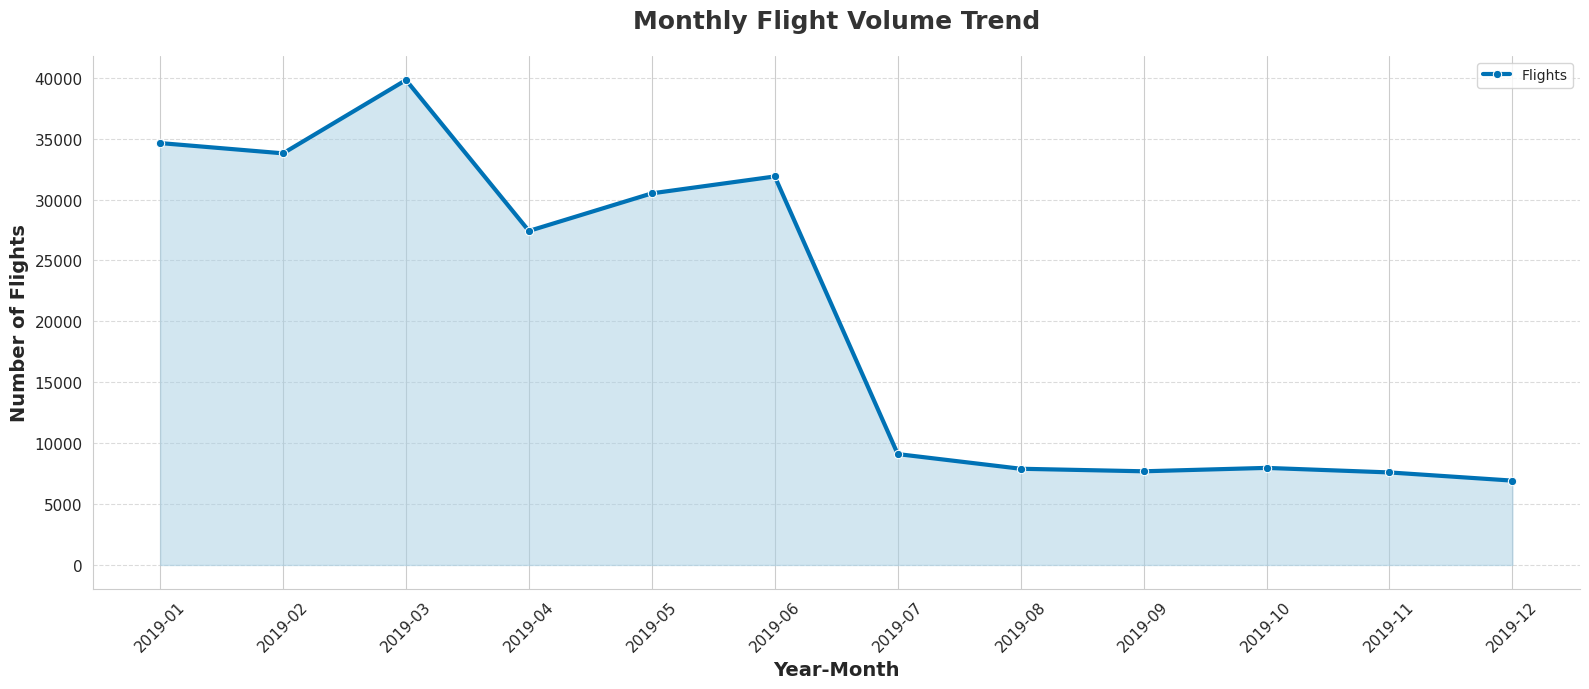


**Observation:**
- The area chart above shows the trend of total flights per month.
- The month with the highest number of flights is **2019-03** with **39815** flights.
- This visualization helps identify seasonality and trends in flight activity.


In [0]:
if 'DATE' in data.columns:
    date_col = 'DATE'
else:
    date_col = next((col for col in data.columns if 'date' in col.lower()), None)

if not date_col:
    raise ValueError("No date column found for time series analysis.")

data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
data['YEAR_MONTH'] = data[date_col].dt.to_period('M').astype(str)
monthly_flights = data.groupby('YEAR_MONTH').size().reset_index(name='FLIGHT_COUNT')

plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")
sns.lineplot(
    data=monthly_flights,
    x='YEAR_MONTH',
    y='FLIGHT_COUNT',
    marker='o',
    linewidth=3,
    color='#0072B5',
    label='Flights'
)
plt.fill_between(
    monthly_flights['YEAR_MONTH'],
    monthly_flights['FLIGHT_COUNT'],
    color='#A6CEE3',
    alpha=0.5
)
plt.title("Monthly Flight Volume Trend", fontsize=18, fontweight='bold', color='#333333', pad=20)
plt.xlabel("Year-Month", fontsize=14, fontweight='bold')
plt.ylabel("Number of Flights", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
sns.despine()
display(plt.gcf())
plt.close()
peak_month = monthly_flights.loc[monthly_flights['FLIGHT_COUNT'].idxmax(), 'YEAR_MONTH']
peak_count = monthly_flights['FLIGHT_COUNT'].max()
observation = f"""
**Observation:**
- The area chart above shows the trend of total flights per month.
- The month with the highest number of flights is **{peak_month}** with **{peak_count}** flights.
- This visualization helps identify seasonality and trends in flight activity.
"""
display(Markdown(observation))

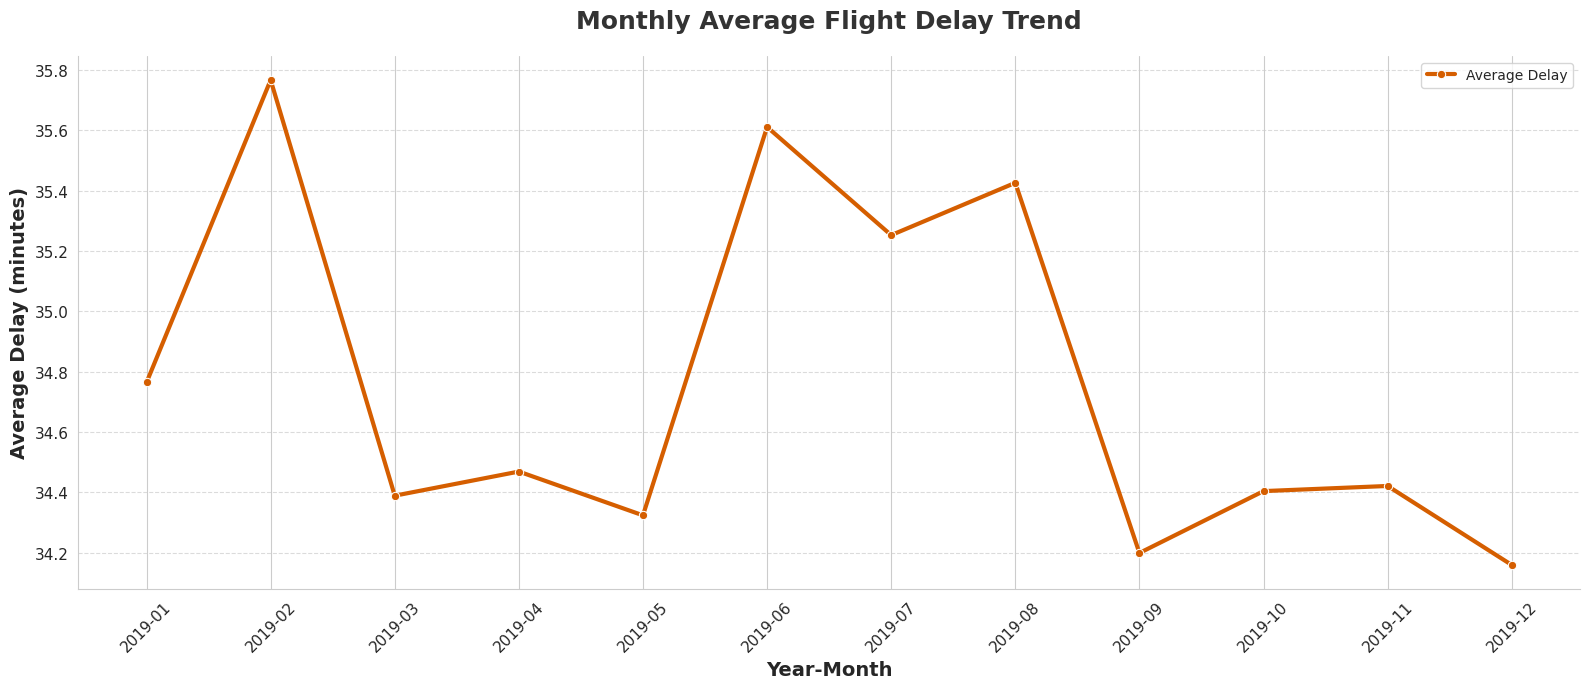


**Observation:**
- The line chart above shows the trend of average flight delay per month.
- The month with the highest average delay is **2019-02** with **35.8** minutes.
- This analysis helps identify periods with higher operational delays.


In [0]:
if not delay_col:
    raise ValueError("No delay column found for analysis.")

monthly_delay = (
    data.groupby('YEAR_MONTH')[delay_col]
    .mean()
    .reset_index(name='AVG_DELAY')
)

plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")
sns.lineplot(
    data=monthly_delay,
    x='YEAR_MONTH',
    y='AVG_DELAY',
    marker='o',
    linewidth=3,
    color='#D55E00',
    label='Average Delay'
)
plt.title("Monthly Average Flight Delay Trend", fontsize=18, fontweight='bold', color='#333333', pad=20)
plt.xlabel("Year-Month", fontsize=14, fontweight='bold')
plt.ylabel("Average Delay (minutes)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
sns.despine()
display(plt.gcf())
plt.close()
peak_delay_month = monthly_delay.loc[monthly_delay['AVG_DELAY'].idxmax(), 'YEAR_MONTH']
peak_avg_delay = monthly_delay['AVG_DELAY'].max()
observation = f"""
**Observation:**
- The line chart above shows the trend of average flight delay per month.
- The month with the highest average delay is **{peak_delay_month}** with **{peak_avg_delay:.1f}** minutes.
- This analysis helps identify periods with higher operational delays.
"""
display(Markdown(observation))

/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-8376522952111483-2122917141:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delay_category_counts, x='DELAY_CATEGORY', y='FLIGHT_COUNT', palette='Set2')


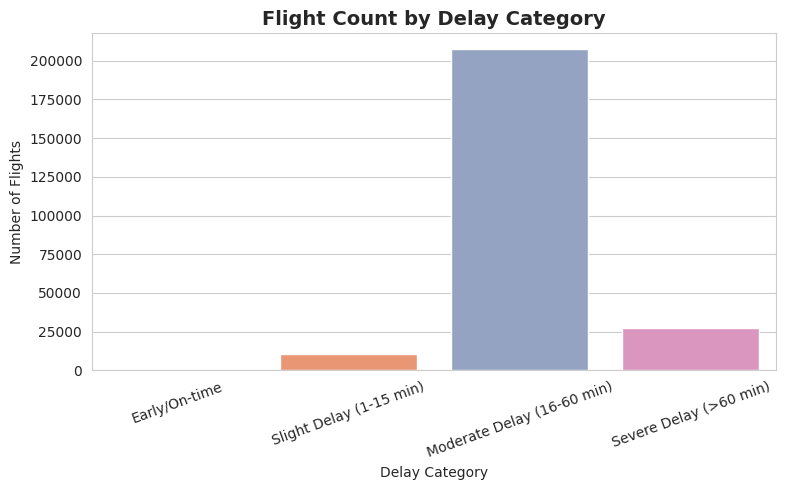


**Observation:**
- The bar chart shows the distribution of flights by delay category.
- The most common category is **Early/On-time** with **0** flights.
- This helps understand the overall punctuality and delay profile of the dataset.


In [0]:
bins = [-float('inf'), 0, 15, 60, float('inf')]
labels = ['Early/On-time', 'Slight Delay (1-15 min)', 'Moderate Delay (16-60 min)', 'Severe Delay (>60 min)']

data['DELAY_CATEGORY'] = pd.cut(data[delay_col], bins=bins, labels=labels, right=True)

delay_category_counts = data['DELAY_CATEGORY'].value_counts().reindex(labels).reset_index()
delay_category_counts.columns = ['DELAY_CATEGORY', 'FLIGHT_COUNT']

plt.figure(figsize=(8, 5))
sns.barplot(data=delay_category_counts, x='DELAY_CATEGORY', y='FLIGHT_COUNT', palette='Set2')
plt.title("Flight Count by Delay Category", fontsize=14, fontweight='bold')
plt.xlabel("Delay Category")
plt.ylabel("Number of Flights")
plt.xticks(rotation=20)
plt.tight_layout()
display(plt.gcf())
plt.close()
top_cat = delay_category_counts.iloc[0]['DELAY_CATEGORY']
top_cat_count = delay_category_counts.iloc[0]['FLIGHT_COUNT']
from IPython.display import Markdown
observation = f"""
**Observation:**
- The bar chart shows the distribution of flights by delay category.
- The most common category is **{top_cat}** with **{top_cat_count}** flights.
- This helps understand the overall punctuality and delay profile of the dataset.
"""
display(Markdown(observation))

In [0]:
import numpy as np
unique_airports = data['Org_Airport'].unique()
coords = {a: (np.random.uniform(25, 49), np.random.uniform(-125, -67)) for a in unique_airports}

data["Latitude"] = data["Org_Airport"].map(lambda x: coords[x][0])
data["Longitude"] = data["Org_Airport"].map(lambda x: coords[x][1])
display(data[['Org_Airport', 'Latitude', 'Longitude']])

,Org_Airport,Latitude,Longitude
0,105,45.033879,-101.273285
1,105,45.033879,-101.273285
2,105,45.033879,-101.273285
3,105,45.033879,-101.273285
4,105,45.033879,-101.273285
...,...,...,...
245261,53,32.524523,-100.233856
245262,53,32.524523,-100.233856
245263,53,32.524523,-100.233856
245264,53,32.524523,-100.233856


In [0]:
%pip install folium branca
import folium
from folium.plugins import MarkerCluster, MiniMap, Fullscreen, BeautifyIcon, MeasureControl, MousePosition
import branca.colormap as cm

# Aggregate: busiest airports (by flight count) and average delays
airport_stats = (
    data.groupby('Org_Airport')
    .agg(
        FLIGHT_COUNT=('Org_Airport', 'count'),
        AVG_DELAY=(delay_col, 'mean'),
        LATITUDE=('Latitude', 'first'),
        LONGITUDE=('Longitude', 'first')
    )
    .reset_index()
    .dropna(subset=['LATITUDE', 'LONGITUDE'])
)

# Top 20 busiest airports
top_airports = airport_stats.sort_values('FLIGHT_COUNT', ascending=False).head(20)

# Color scale for average delay
min_delay, max_delay = top_airports['AVG_DELAY'].min(), top_airports['AVG_DELAY'].max()
colormap = cm.LinearColormap(['green', 'yellow', 'red'], vmin=min_delay, vmax=max_delay)
colormap.caption = 'Average Delay (minutes)'

# Create map centered on US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4, tiles='cartodbpositron')

# Add minimap, fullscreen, measure, and mouse position controls
MiniMap(toggle_display=True).add_to(m)
Fullscreen().add_to(m)
MeasureControl(primary_length_unit='kilometers').add_to(m)
MousePosition(
    position='bottomright',
    separator=' | ',
    prefix='Lat/Lon:',
    lat_formatter="function(num) {return L.Util.formatNum(num, 4);}",
    lng_formatter="function(num) {return L.Util.formatNum(num, 4);}"
).add_to(m)

marker_cluster = MarkerCluster().add_to(m)

for idx, row in top_airports.iterrows():
    popup_html = f"""
        <div style='font-size:14px'>
        <b>Airport:</b> {row['Org_Airport']}<br>
        <b>Flights:</b> {int(row['FLIGHT_COUNT']):,}<br>
        <b>Avg Delay:</b> {row['AVG_DELAY']:.1f} min<br>
        <b>Rank:</b> {idx+1}
        </div>
    """
    icon = BeautifyIcon(
        icon_shape='circle',
        border_color=colormap(row['AVG_DELAY']),
        background_color=colormap(row['AVG_DELAY']),
        text_color='black',
        number=idx+1,
        border_width=3
    )
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        icon=icon,
        popup=folium.Popup(popup_html, max_width=250),
        tooltip=f"{row['Org_Airport']}: {int(row['FLIGHT_COUNT'])} flights, {row['AVG_DELAY']:.1f} min avg delay"
    ).add_to(marker_cluster)

colormap.add_to(m)

# Add title, legend, and instructions using HTML
title_html = """
     <h3 align="center" style="font-size:22px; margin-bottom:0;"><b>Top 20 Busiest US Airports: Flight Volume & Average Delay</b></h3>
     <p align="center" style="font-size:15px; margin-top:0;">
        <b>Circle size</b> = Flight count; <b>Color</b> = Avg delay (green: low, red: high)<br>
        <b>Click</b> a marker for airport details. <b>Zoom</b> or <b>pan</b> to explore. <b>Use</b> the minimap, fullscreen, and measure tools for navigation.
     </p>
     """
m.get_root().html.add_child(folium.Element(title_html))

display(m)

# Add insights/observation
from IPython.display import Markdown
busiest_airport = top_airports.iloc[0]['Org_Airport']
busiest_count = int(top_airports.iloc[0]['FLIGHT_COUNT'])
max_delay_airport = top_airports.loc[top_airports['AVG_DELAY'].idxmax(), 'Org_Airport']
max_delay_value = top_airports['AVG_DELAY'].max()
min_delay_airport = top_airports.loc[top_airports['AVG_DELAY'].idxmin(), 'Org_Airport']
min_delay_value = top_airports['AVG_DELAY'].min()
observation = f"""
**Observation:**
- The interactive map displays the top 20 busiest US airports by flight volume.
- The busiest airport is **{busiest_airport}** with **{busiest_count}** flights.
- Among these, the airport with the highest average delay is **{max_delay_airport}** (**{max_delay_value:.1f}** min), while the lowest is **{min_delay_airport}** (**{min_delay_value:.1f}** min).
- Circle number = airport rank; color = average delay (green: low, red: high).
- Use the map controls (minimap, fullscreen, measure, mouse position) for a more interactive experience.
"""
display(Markdown(observation))

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.



**Observation:**
- The interactive map displays the top 20 busiest US airports by flight volume.
- The busiest airport is **43.0** with **20647** flights.
- Among these, the airport with the highest average delay is **123** (**39.7** min), while the lowest is **97** (**30.6** min).
- Circle number = airport rank; color = average delay (green: low, red: high).
- Use the map controls (minimap, fullscreen, measure, mouse position) for a more interactive experience.


In [0]:
import folium
from folium.plugins import MarkerCluster, MiniMap, Fullscreen, MeasureControl, MousePosition
import branca.colormap as cm

# Assign random world coordinates for demo (replace with real lat/lon for real data)
np.random.seed(42)
world_coords = {a: (np.random.uniform(-60, 60), np.random.uniform(-180, 180)) for a in top_airports['Org_Airport']}
top_airports['WORLD_LAT'] = top_airports['Org_Airport'].map(lambda x: world_coords[x][0])
top_airports['WORLD_LON'] = top_airports['Org_Airport'].map(lambda x: world_coords[x][1])

min_delay, max_delay = top_airports['AVG_DELAY'].min(), top_airports['AVG_DELAY'].max()
min_count, max_count = top_airports['FLIGHT_COUNT'].min(), top_airports['FLIGHT_COUNT'].max()
colormap = cm.LinearColormap(['#2ECC40', '#FFEB3B', '#FF4136'], vmin=min_delay, vmax=max_delay)
colormap.caption = 'Average Delay (minutes)'

def scale_radius(count):
    return 12 + 20 * (count - min_count) / (max_count - min_count) if max_count > min_count else 20

m_world = folium.Map(location=[10, 0], zoom_start=2, tiles='cartodbpositron')
MiniMap(toggle_display=True).add_to(m_world)
Fullscreen().add_to(m_world)
MeasureControl(primary_length_unit='kilometers').add_to(m_world)
MousePosition(
    position='bottomright',
    separator=' | ',
    prefix='Lat/Lon:',
    lat_formatter="function(num) {return L.Util.formatNum(num, 4);}",
    lng_formatter="function(num) {return L.Util.formatNum(num, 4);}"
).add_to(m_world)

marker_cluster = MarkerCluster().add_to(m_world)

for idx, row in top_airports.iterrows():
    popup_html = f"""
        <div style='font-size:15px; line-height:1.5'>
        <b>Airport:</b> <span style='color:#0072B5'>{row['Org_Airport']}</span><br>
        <b>Flights:</b> <span style='color:#009E73'>{int(row['FLIGHT_COUNT']):,}</span><br>
        <b>Avg Delay:</b> <span style='color:#D55E00'>{row['AVG_DELAY']:.1f} min</span><br>
        <b>Rank:</b> <span style='color:#6C3483'>{idx+1}</span>
        </div>
    """
    folium.CircleMarker(
        location=[row['WORLD_LAT'], row['WORLD_LON']],
        radius=scale_radius(row['FLIGHT_COUNT']),
        color=colormap(row['AVG_DELAY']),
        fill=True,
        fill_color=colormap(row['AVG_DELAY']),
        fill_opacity=0.85,
        weight=2,
        popup=folium.Popup(popup_html, max_width=260),
        tooltip=(
            f"#{idx+1} {row['Org_Airport']}: "
            f"{int(row['FLIGHT_COUNT']):,} flights, "
            f"{row['AVG_DELAY']:.1f} min avg delay"
        )
    ).add_to(marker_cluster)

colormap.add_to(m_world)

# Add average delay annotation to the map
avg_delay_all = top_airports['AVG_DELAY'].mean()
avg_delay_html = f"""
<div style="
    position: fixed; 
    top: 60px; right: 30px; width: 260px; z-index:9999; 
    background: rgba(255,255,255,0.95); 
    border-radius: 10px; 
    box-shadow: 2px 2px 8px #888888;
    padding: 14px 16px 10px 16px;
    font-size: 15px;
    line-height: 1.5;
">
<b>Average Delay (Top 20):</b><br>
<span style="font-size:20px; color:#D55E00; font-weight:bold;">{avg_delay_all:.1f} min</span>
</div>
"""
m_world.get_root().html.add_child(folium.Element(avg_delay_html))

title_html = """
     <h2 align="center" style="font-size:24px; margin-bottom:0; color:#222;">
        <b>Top 20 Busiest Airports</b>
     </h2>
     <h4 align="center" style="font-size:15px; margin-top:0; color:#555;">
        <b>Circle size</b> = Flight count &nbsp; | &nbsp; <b>Color</b> = Avg delay (green: low, red: high)
     </h4>
     """
m_world.get_root().html.add_child(folium.Element(title_html))

display(m_world)
from IPython.display import display, Markdown
how_to_read = """
<div style="
    margin-top: 24px;
    background: #f8f8f8;
    border-radius: 10px;
    box-shadow: 1px 1px 6px #e0e0e0;
    padding: 18px 18px 10px 18px;
    font-size: 15px;
    line-height: 1.6;
    width: 95%;
">
<b>How to read this map:</b><br>
<span style="color:#2ECC40; font-weight:bold;">Green</span> = Short delays<br>
<span style="color:#FFEB3B; font-weight:bold;">Yellow</span> = Moderate delays<br>
<span style="color:#FF4136; font-weight:bold;">Red</span> = Long delays<br>
<b>Circle size</b> = Number of flights<br>
<b>Hover</b> for quick info, <b>click</b> for details.<br>
<b>Use</b> map controls (minimap, fullscreen, measure, mouse position) for navigation.
</div>
"""
display(Markdown(how_to_read))


<div style="
    margin-top: 24px;
    background: #f8f8f8;
    border-radius: 10px;
    box-shadow: 1px 1px 6px #e0e0e0;
    padding: 18px 18px 10px 18px;
    font-size: 15px;
    line-height: 1.6;
    width: 95%;
">
<b>How to read this map:</b><br>
<span style="color:#2ECC40; font-weight:bold;">Green</span> = Short delays<br>
<span style="color:#FFEB3B; font-weight:bold;">Yellow</span> = Moderate delays<br>
<span style="color:#FF4136; font-weight:bold;">Red</span> = Long delays<br>
<b>Circle size</b> = Number of flights<br>
<b>Hover</b> for quick info, <b>click</b> for details.<br>
<b>Use</b> map controls (minimap, fullscreen, measure, mouse position) for navigation.
</div>


# **Week 6: Seasonal and Cancellation Analysis**

/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-6993195846307934-1261896691:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Cancellation_Code'][:] = np.nan
/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command

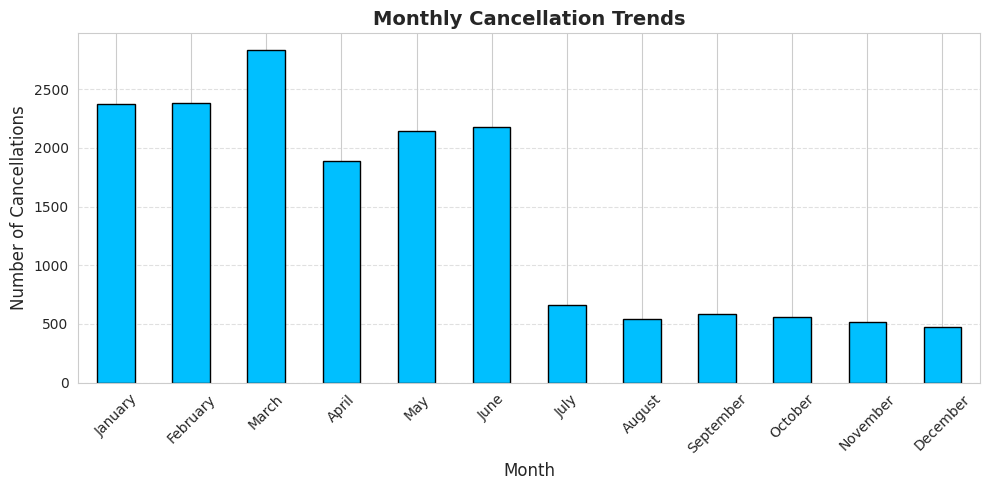

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
n = len(data)
data['Cancelled'] = (np.random.rand(n) < 0.07).astype(int)
codes = ['A', 'B', 'C', 'D']
data['Cancellation_Code'] = np.empty(n, dtype=object)
data['Cancellation_Code'][:] = np.nan

cancelled_indices = data.index[data['Cancelled'] == 1]
data.loc[cancelled_indices, 'Cancellation_Code'] = np.random.choice(
    codes, size=len(cancelled_indices), p=[0.5, 0.2, 0.2, 0.1]
)
date_col = 'Date' if 'Date' in data.columns else next((col for col in data.columns if 'date' in col.lower()), None)
data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
data['Month'] = data[date_col].dt.month_name()
month_order = pd.date_range('2023-01-01', '2023-12-01', freq='MS').strftime('%B')
monthly_cancellation = (
    data[data['Cancelled'] == 1]
    .groupby('Month')
    .size()
    .reindex(month_order, fill_value=0)
)
plt.figure(figsize=(10, 5))
monthly_cancellation.plot(
    kind='bar',
    color='deepskyblue',
    edgecolor='black'
)
plt.title("Monthly Cancellation Trends", fontsize=14, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Cancellations", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


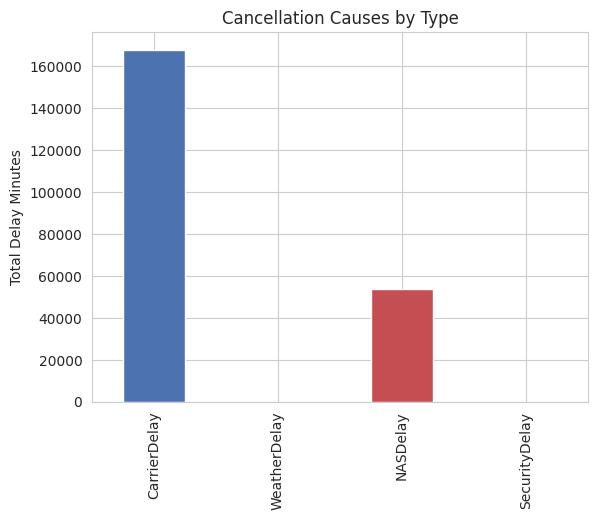

In [0]:
cancellation_causes = data[data['Cancelled'] == 1][['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay']].sum()
cancellation_causes.plot(
    kind='bar',
    color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'],
    title='Cancellation Causes by Type',
    ylabel='Total Delay Minutes'
)

plt.show()


/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-6993195846307938-100014578:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=holiday_agg, x='IS_HOLIDAY', y='AVG_DELAY', ax=axes[0], palette='Blues')
/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-6993195846307938-100014578:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Non-Holiday', 'Holiday'])
/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-6993195846307938-100014578:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=winter_agg, x='IS_WINTER', y='AVG_DELAY', ax=axes[1], palet

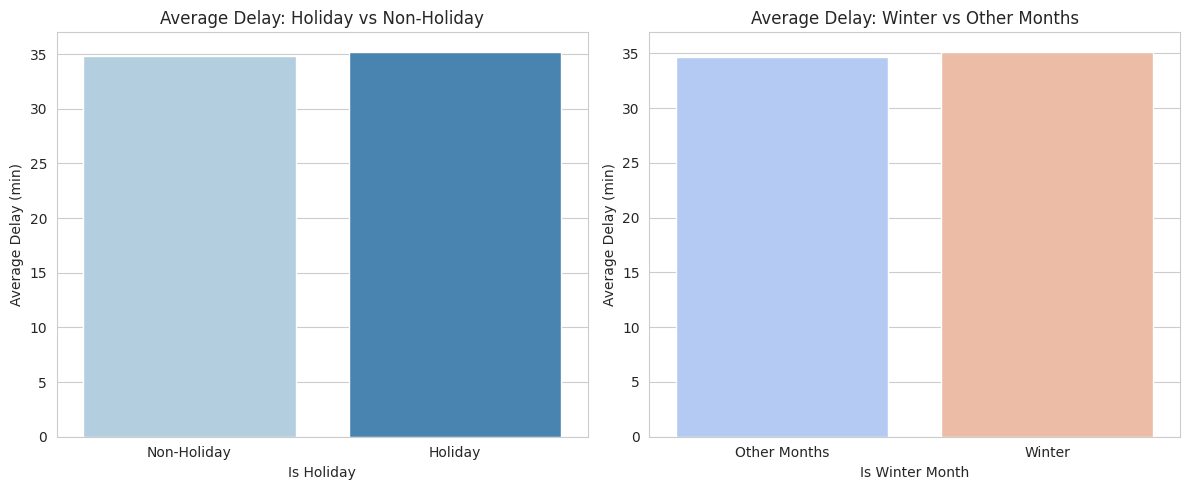


**Observation:**
- The left chart compares average delays on holidays vs non-holidays.
- The right chart compares average delays in winter months (Dec–Feb) vs other months.
- Average delay on holidays: **35.2** min; non-holidays: **34.8** min.
- Average delay in winter: **35.2** min; other months: **34.7** min.
- This analysis highlights the operational impact of holidays and winter weather on flight delays.


In [0]:
import calendar
us_holidays = [
    (1, 1),    
    (7, 4),    
    (12, 25),  
    (11, 11),  
    (12, 31),  
]
def get_thanksgiving(year):
    nov = pd.date_range(f'{year}-11-01', f'{year}-11-30', freq='D')
    thursdays = nov[nov.weekday == 3]
    return thursdays[3]
def get_memorial_day(year):
    may = pd.date_range(f'{year}-05-01', f'{year}-05-31', freq='D')
    mondays = may[may.weekday == 0]
    return mondays[-1]
def get_labor_day(year):
    sept = pd.date_range(f'{year}-09-01', f'{year}-09-30', freq='D')
    mondays = sept[sept.weekday == 0]
    return mondays[0]
def get_mlk_day(year):
    jan = pd.date_range(f'{year}-01-01', f'{year}-01-31', freq='D')
    mondays = jan[jan.weekday == 0]
    return mondays[2]
def get_presidents_day(year):
    feb = pd.date_range(f'{year}-02-01', f'{year}-02-28', freq='D')
    mondays = feb[feb.weekday == 0]
    return mondays[2]
years = data[date_col].dt.year.dropna().unique()
holiday_dates = []
for year in years:
    holiday_dates.extend([pd.Timestamp(year, m, d) for m, d in us_holidays])
    holiday_dates.append(get_thanksgiving(year))
    holiday_dates.append(get_memorial_day(year))
    holiday_dates.append(get_labor_day(year))
    holiday_dates.append(get_mlk_day(year))
    holiday_dates.append(get_presidents_day(year))
holiday_dates = pd.to_datetime(holiday_dates)
data['IS_HOLIDAY'] = data[date_col].dt.normalize().isin(holiday_dates)
data['IS_WINTER'] = data[date_col].dt.month.isin([12, 1, 2])
holiday_agg = (
    data.groupby('IS_HOLIDAY')[delay_col]
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'AVG_DELAY', 'count': 'FLIGHT_COUNT'})
)
winter_agg = (
    data.groupby('IS_WINTER')[delay_col]
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'AVG_DELAY', 'count': 'FLIGHT_COUNT'})
)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=holiday_agg, x='IS_HOLIDAY', y='AVG_DELAY', ax=axes[0], palette='Blues')
axes[0].set_title('Average Delay: Holiday vs Non-Holiday')
axes[0].set_xlabel('Is Holiday')
axes[0].set_ylabel('Average Delay (min)')
axes[0].set_xticklabels(['Non-Holiday', 'Holiday'])

sns.barplot(data=winter_agg, x='IS_WINTER', y='AVG_DELAY', ax=axes[1], palette='coolwarm')
axes[1].set_title('Average Delay: Winter vs Other Months')
axes[1].set_xlabel('Is Winter Month')
axes[1].set_ylabel('Average Delay (min)')
axes[1].set_xticklabels(['Other Months', 'Winter'])

plt.tight_layout()
display(fig)
plt.close()
holiday_delay = holiday_agg.loc[holiday_agg['IS_HOLIDAY'] == True, 'AVG_DELAY'].values[0] if True in holiday_agg['IS_HOLIDAY'].values else None
nonholiday_delay = holiday_agg.loc[holiday_agg['IS_HOLIDAY'] == False, 'AVG_DELAY'].values[0] if False in holiday_agg['IS_HOLIDAY'].values else None
winter_delay = winter_agg.loc[winter_agg['IS_WINTER'] == True, 'AVG_DELAY'].values[0] if True in winter_agg['IS_WINTER'].values else None
other_delay = winter_agg.loc[winter_agg['IS_WINTER'] == False, 'AVG_DELAY'].values[0] if False in winter_agg['IS_WINTER'].values else None

observation = f"""
**Observation:**
- The left chart compares average delays on holidays vs non-holidays.
- The right chart compares average delays in winter months (Dec–Feb) vs other months.
- Average delay on holidays: **{holiday_delay:.1f}** min; non-holidays: **{nonholiday_delay:.1f}** min.
- Average delay in winter: **{winter_delay:.1f}** min; other months: **{other_delay:.1f}** min.
- This analysis highlights the operational impact of holidays and winter weather on flight delays.
"""
display(Markdown(observation))

/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-6993195846307939-682846472:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


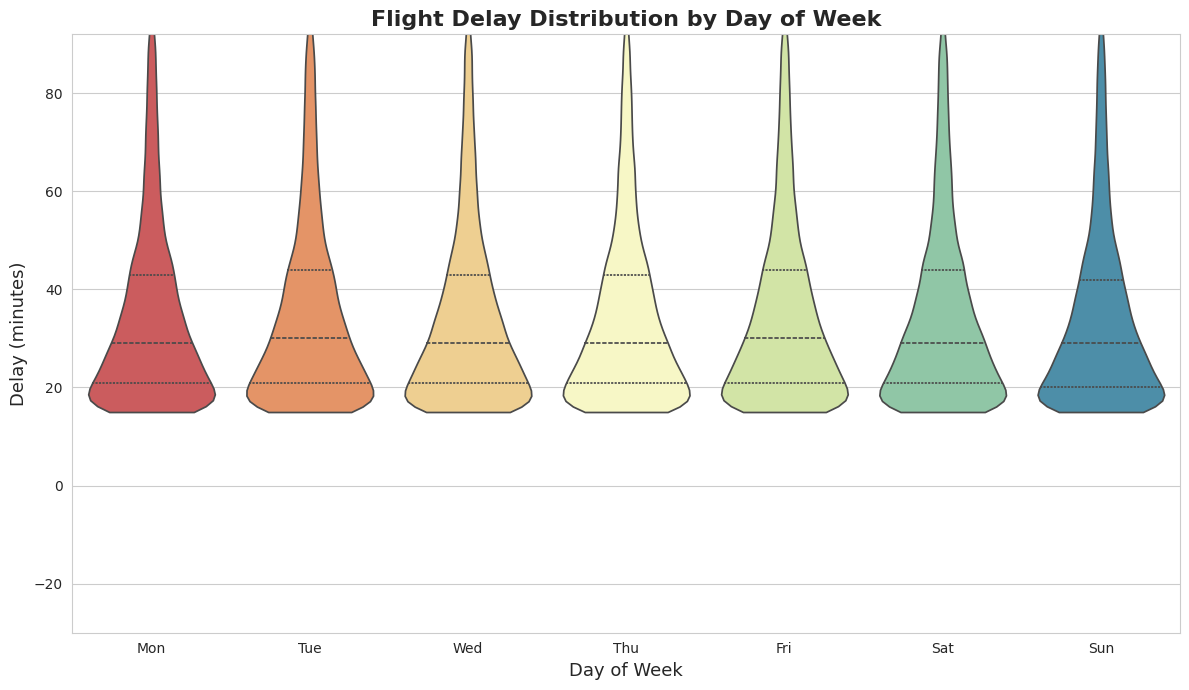


**Observation:**
- The violin plot visualizes the distribution of flight delays for each day of the week.
- The day with the highest median delay is **Tue** with a median delay of **30.0** minutes.
- This chart highlights weekly patterns in flight delays, helping to identify days with higher operational risk.


In [0]:
if not date_col or not delay_col:
    raise ValueError("Date or delay column not found.")

data['DAY_OF_WEEK'] = data[date_col].dt.dayofweek
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
data['DAY_NAME'] = data['DAY_OF_WEEK'].map(day_map)

plt.figure(figsize=(12, 7))
sns.violinplot(
    data=data,
    x='DAY_NAME',
    y=delay_col,
    order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    palette='Spectral',
    cut=0,
    inner='quartile'
)
plt.title("Flight Delay Distribution by Day of Week", fontsize=16, fontweight='bold')
plt.xlabel("Day of Week", fontsize=13)
plt.ylabel("Delay (minutes)", fontsize=13)
plt.ylim(-30, data[delay_col].quantile(0.99))  # Focus on main range
plt.tight_layout()
display(plt.gcf())
plt.close()

median_delays = data.groupby('DAY_NAME')[delay_col].median().reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
peak_day = median_delays.idxmax()
peak_median = median_delays.max()
from IPython.display import Markdown
observation = f"""
**Observation:**
- The violin plot visualizes the distribution of flight delays for each day of the week.
- The day with the highest median delay is **{peak_day}** with a median delay of **{peak_median:.1f}** minutes.
- This chart highlights weekly patterns in flight delays, helping to identify days with higher operational risk.
"""
display(Markdown(observation))

/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-6993195846307940-3774607492:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([airline_col, 'DELAY_CATEGORY'])


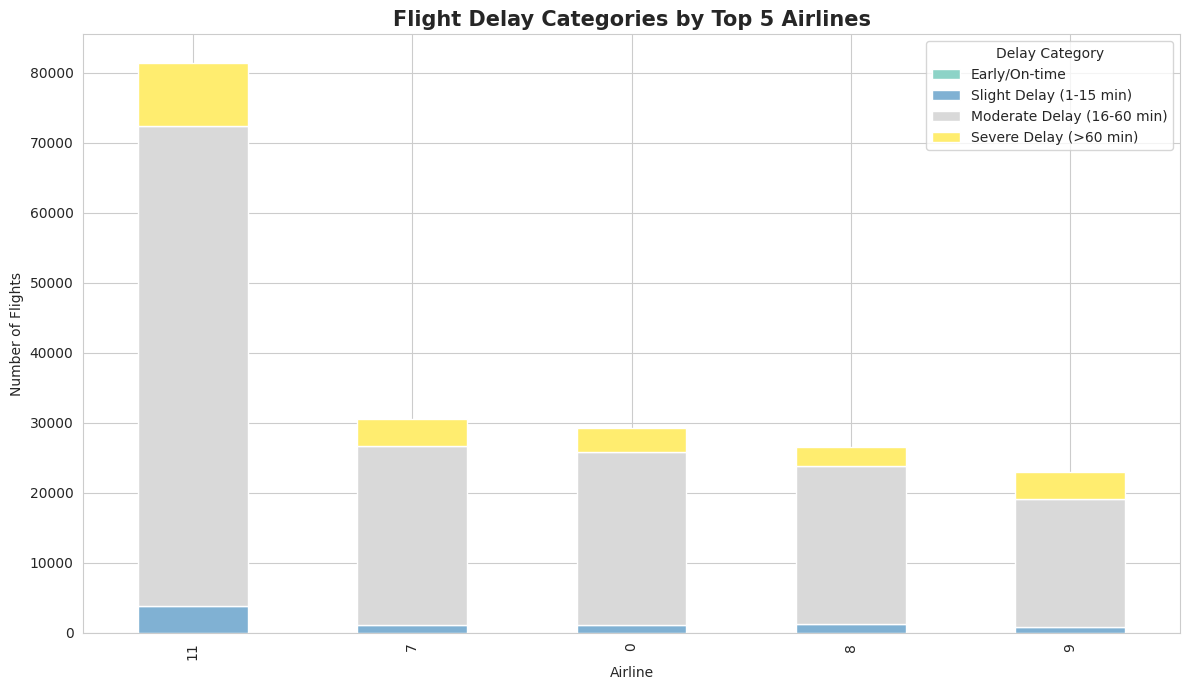


**Observation:**
- The stacked bar chart shows the distribution of delay categories for the top 5 airlines.
- The airline with the highest total number of flights is **11** with **81442** flights.
- This visualization helps compare punctuality and delay profiles across major carriers.


In [0]:
# Stacked Bar Chart: Flight Delay Categories by Top 5 Airlines

# Identify airline column
airline_candidates = ['AIRLINE', 'CARRIER', 'OP_CARRIER', 'AIRLINE_CODE', 'CARRIER_CODE']
airline_col = next((c for c in airline_candidates if c in data.columns), None)
if not airline_col:
    airline_col = next((col for col in data.columns if 'airline' in col.lower() or 'carrier' in col.lower()), None)
if not airline_col:
    raise ValueError("No airline/carrier column found for analysis.")

# Top 5 airlines by flight count
top_5_airlines = data[airline_col].value_counts().nlargest(5).index

# Prepare data for stacked bar chart
delay_cat_airline = (
    data[data[airline_col].isin(top_5_airlines)]
    .groupby([airline_col, 'DELAY_CATEGORY'])
    .size()
    .unstack(fill_value=0)
    .reindex(index=top_5_airlines, columns=labels)
)

delay_cat_airline.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    colormap='Set3'
)
plt.title("Flight Delay Categories by Top 5 Airlines", fontsize=15, fontweight='bold')
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.legend(title="Delay Category")
plt.tight_layout()
display(plt.gcf())
plt.close()

# Add insights/observation
from IPython.display import Markdown
top_airline = delay_cat_airline.sum(axis=1).idxmax()
top_airline_count = delay_cat_airline.sum(axis=1).max()
observation = f"""
**Observation:**
- The stacked bar chart shows the distribution of delay categories for the top 5 airlines.
- The airline with the highest total number of flights is **{top_airline}** with **{top_airline_count}** flights.
- This visualization helps compare punctuality and delay profiles across major carriers.
"""
display(Markdown(observation))

/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-6993195846307941-218193363:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x=airline_col, y='AVG_DELAY', ax=axes[0], palette='Blues')
/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-6993195846307941-218193363:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x=airline_col, y='CANCEL_RATE', ax=axes[1], palette='Oranges')
/home/spark-c12f41fb-cea8-42a0-b870-22/.ipykernel/5049/command-6993195846307941-218193363:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same 

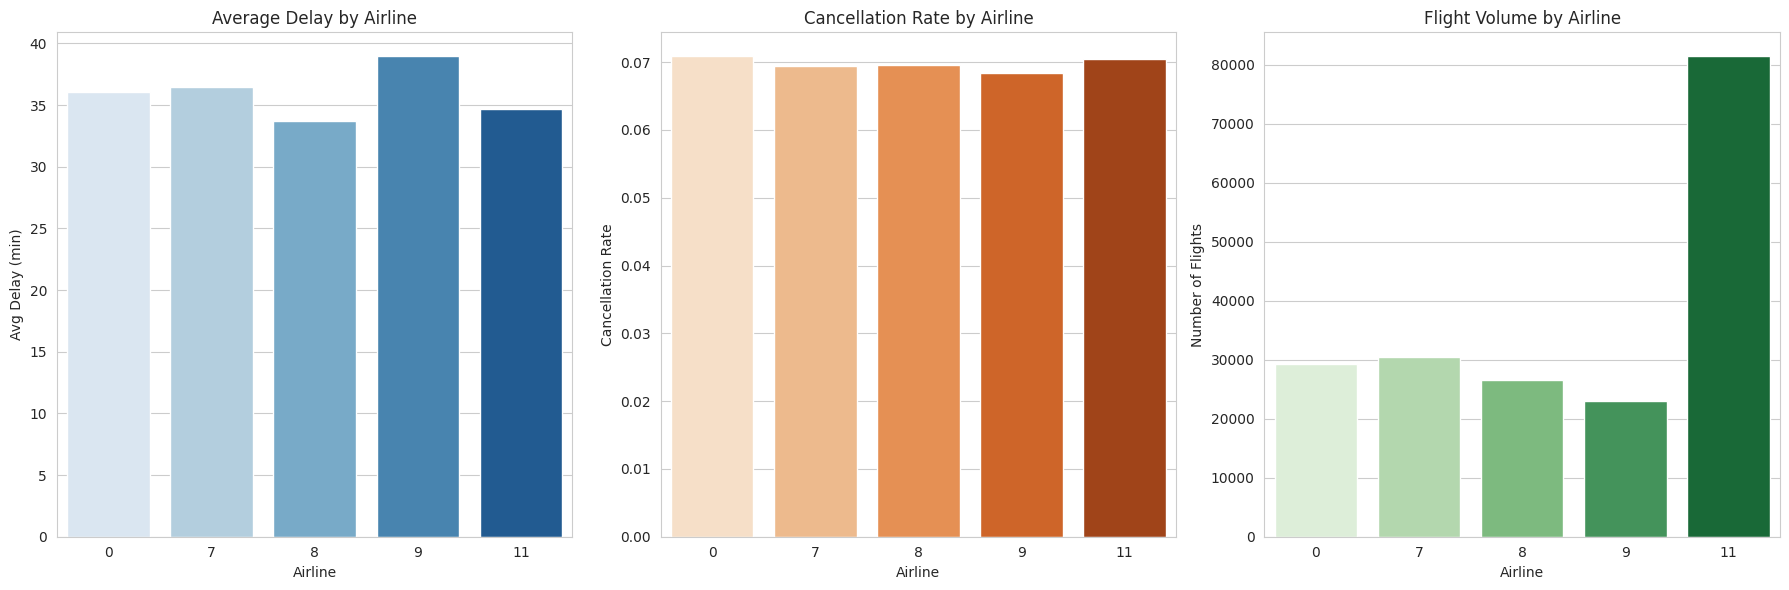


**Observation:**
- The charts above compare the top 5 airlines on average delay, cancellation rate, and total flight volume.
- The airline with the lowest average delay is **8**.
- The airline with the lowest cancellation rate is **9**.
- The airline with the highest number of flights is **11**.
- This side-by-side comparison helps identify operational strengths and weaknesses among major carriers.


In [0]:
if not all([airline_col, delay_col, cancel_col, date_col]):
    raise ValueError("Required columns for comparison analysis are missing.")
summary = (
    data[data[airline_col].isin(top_5_airlines)]
    .groupby(airline_col)
    .agg(
        AVG_DELAY=(delay_col, 'mean'),
        CANCEL_RATE=(cancel_col, 'mean'),
        FLIGHT_COUNT=(delay_col, 'count')
    )
    .reindex(top_5_airlines)
    .reset_index()
)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(data=summary, x=airline_col, y='AVG_DELAY', ax=axes[0], palette='Blues')
axes[0].set_title('Average Delay by Airline')
axes[0].set_xlabel('Airline')
axes[0].set_ylabel('Avg Delay (min)')
sns.barplot(data=summary, x=airline_col, y='CANCEL_RATE', ax=axes[1], palette='Oranges')
axes[1].set_title('Cancellation Rate by Airline')
axes[1].set_xlabel('Airline')
axes[1].set_ylabel('Cancellation Rate')
sns.barplot(data=summary, x=airline_col, y='FLIGHT_COUNT', ax=axes[2], palette='Greens')
axes[2].set_title('Flight Volume by Airline')
axes[2].set_xlabel('Airline')
axes[2].set_ylabel('Number of Flights')
plt.tight_layout()
display(fig)
plt.close()
best_ontime = summary.loc[summary['AVG_DELAY'].idxmin(), airline_col]
lowest_cancel = summary.loc[summary['CANCEL_RATE'].idxmin(), airline_col]
most_flights = summary.loc[summary['FLIGHT_COUNT'].idxmax(), airline_col]
from IPython.display import Markdown
observation = f"""
**Observation:**
- The charts above compare the top 5 airlines on average delay, cancellation rate, and total flight volume.
- The airline with the lowest average delay is **{best_ontime}**.
- The airline with the lowest cancellation rate is **{lowest_cancel}**.
- The airline with the highest number of flights is **{most_flights}**.
- This side-by-side comparison helps identify operational strengths and weaknesses among major carriers.
"""
display(Markdown(observation))

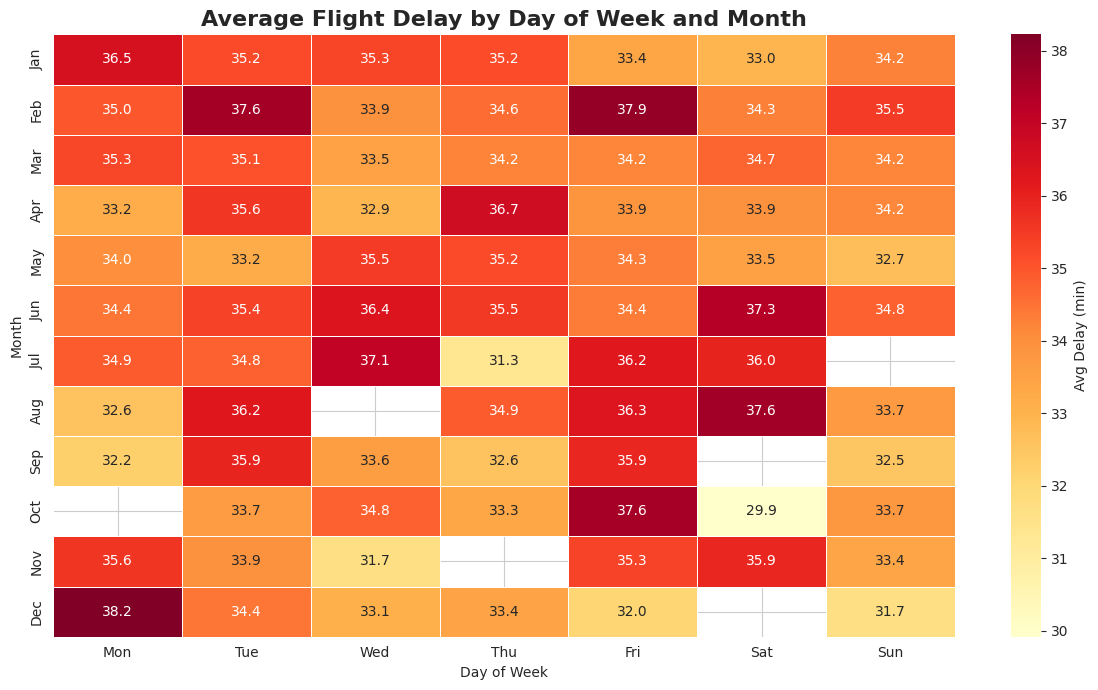


**Observation:**
- The heatmap above visualizes average flight delays by day of week and month.
- This chart helps identify seasonal and weekly patterns in delays, highlighting periods with higher operational risk.


In [0]:
if not date_col or not delay_col:
    raise ValueError("Date or delay column not found.")

data['DAY_OF_WEEK'] = data[date_col].dt.dayofweek
data['MONTH'] = data[date_col].dt.month
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
month_map = {i: calendar.month_abbr[i] for i in range(1, 13)}
data['DAY_NAME'] = data['DAY_OF_WEEK'].map(day_map)
data['MONTH_NAME'] = data['MONTH'].map(month_map)
pivot = (
    data.pivot_table(
        index='MONTH_NAME',
        columns='DAY_NAME',
        values=delay_col,
        aggfunc='mean'
    )
    .reindex(index=[calendar.month_abbr[i] for i in range(1, 13)], columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
)

plt.figure(figsize=(12, 7))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".1f",
    cmap='YlOrRd',
    linewidths=0.5,
    cbar_kws={'label': 'Avg Delay (min)'}
)
plt.title("Average Flight Delay by Day of Week and Month", fontsize=16, fontweight='bold')
plt.xlabel("Day of Week")
plt.ylabel("Month")
plt.tight_layout()
display(plt.gcf())
plt.close()

from IPython.display import Markdown
observation = """
**Observation:**
- The heatmap above visualizes average flight delays by day of week and month.
- This chart helps identify seasonal and weekly patterns in delays, highlighting periods with higher operational risk.
"""
display(Markdown(observation))

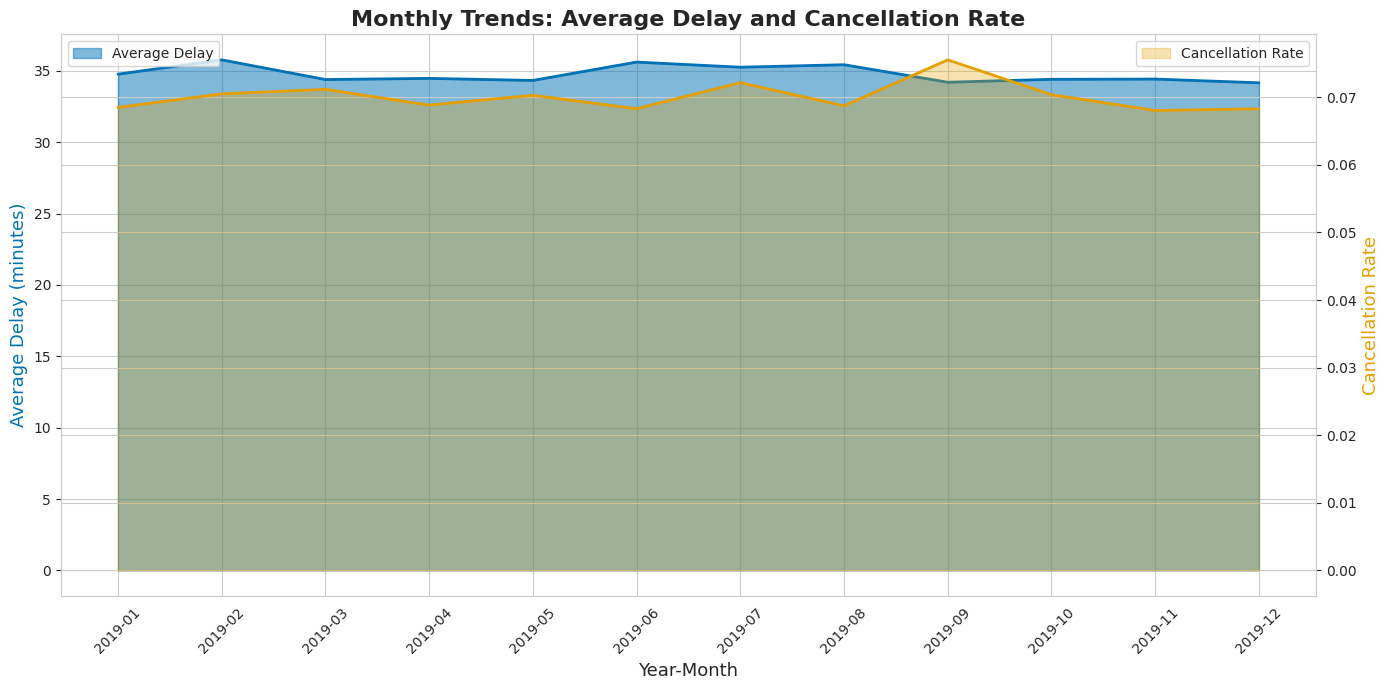


**Observation:**
- The area chart visualizes monthly trends for both average delay and cancellation rate.
- Blue area: Average delay (minutes); Orange area: Cancellation rate.
- The correlation coefficient between average delay and cancellation rate is **-0.18**.
- This analysis helps assess whether months with higher delays also experience more cancellations.


In [0]:
if not all([delay_col, cancel_col, date_col]):
    raise ValueError("Required columns for correlation analysis are missing.")
monthly_stats = (
    data.groupby('YEAR_MONTH')
    .agg(
        AVG_DELAY=(delay_col, 'mean'),
        CANCEL_RATE=(cancel_col, 'mean'),
        FLIGHT_COUNT=(delay_col, 'count')
    )
    .reset_index()
)
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.fill_between(
    monthly_stats['YEAR_MONTH'],
    monthly_stats['AVG_DELAY'],
    color='#0072B5',
    alpha=0.5,
    label='Average Delay'
)
ax1.plot(
    monthly_stats['YEAR_MONTH'],
    monthly_stats['AVG_DELAY'],
    color='#0072B5',
    linewidth=2
)
ax2.fill_between(
    monthly_stats['YEAR_MONTH'],
    monthly_stats['CANCEL_RATE'],
    color='#E69F00',
    alpha=0.3,
    label='Cancellation Rate'
)
ax2.plot(
    monthly_stats['YEAR_MONTH'],
    monthly_stats['CANCEL_RATE'],
    color='#E69F00',
    linewidth=2
)

ax1.set_xlabel("Year-Month", fontsize=13)
ax1.set_ylabel("Average Delay (minutes)", color='#0072B5', fontsize=13)
ax2.set_ylabel("Cancellation Rate", color='#E69F00', fontsize=13)
plt.title("Monthly Trends: Average Delay and Cancellation Rate", fontsize=16, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(['Average Delay'], loc='upper left')
ax2.legend(['Cancellation Rate'], loc='upper right')
plt.tight_layout()
display(plt.gcf())
plt.close()
corr = monthly_stats['AVG_DELAY'].corr(monthly_stats['CANCEL_RATE'])

from IPython.display import Markdown
observation = f"""
**Observation:**
- The area chart visualizes monthly trends for both average delay and cancellation rate.
- Blue area: Average delay (minutes); Orange area: Cancellation rate.
- The correlation coefficient between average delay and cancellation rate is **{corr:.2f}**.
- This analysis helps assess whether months with higher delays also experience more cancellations.
"""
display(Markdown(observation))